This notebook includes:



1)the WLS analysis of particulate and dissolved Pa, 


2)the F-statistic 

3)and the map.

In [1]:
import numpy as np
import numpy
import math
import os
import glob,csv
import pandas as pd
from pylab import *
from netCDF4 import Dataset
import pylab as pl
from mpl_toolkits.basemap import Basemap,shiftgrid,cm
import matplotlib.cm as cm
from scipy.stats import f as scist

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
% matplotlib inline

nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/*.csv'))
print len(nc_filename)
print("found *.csv file: \n{}".format(nc_filename))

7
found *.csv file: 
['/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/32_1.csv', '/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/60changed.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/60changed2.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/60changed3.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/60changed4.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/60changed6.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Pa/abondant_60changed5.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv']


#Fitting the part. Pa

In [2]:
file_num=6
marker=['D','s','s','s','s','s','s']

WLS_err1=np.empty([file_num,1])
WLS_coef1=np.empty([file_num,1])
WLS_errc=np.empty([file_num,1])
WLS_coefc=np.empty([file_num,1])
sinking_rate=np.empty([file_num,1])

rss1=np.empty([file_num,1])
rss2=np.empty([file_num,1])


1999 IOC
F ratio: -0.30765380475
ftest:1.0
slope:2.058645e-06,error:2.082801e-05
C1   :-4.052428e-04,error:3.622653e-02
sinking   :1.194961e+03,error:1.208983e+04

1991 ARCTIC EXPEDITION Stn1
F ratio: 1.61436605677
ftest:0.272750096258
slope:1.860289e-06,error:7.270330e-07
C1   :2.874555e-03,error:1.777819e-03
sinking   :1.322375e+03,error:5.168070e+02

1991 ARCTIC EXPEDITION Stn2
F ratio: 2.05131656115
ftest:0.225344806825
slope:1.889270e-06,error:1.059337e-06
C1   :5.168910e-03,error:3.244229e-03
sinking   :1.302090e+03,error:7.300980e+02

1991 ARCTIC EXPEDITION Stn3
F ratio: 40.4794620794
ftest:0.00312852295358
slope:1.938357e-06,error:4.193116e-07
C1   :5.877129e-03,error:8.181694e-04
sinking   :1.269116e+03,error:2.745391e+02

1991 ARCTIC EXPEDITION Stn4
F ratio: 15.7151667924
ftest:0.0166186139955
slope:1.421035e-06,error:4.467059e-07
C1   :4.514722e-03,error:1.104271e-03
sinking   :1.731133e+03,error:5.441862e+02

1991 ARCTIC EXPEDITION Stn6
F ratio: -0.410876222283
ftest:1.0
s

/home/xiaoxiny/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3855: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


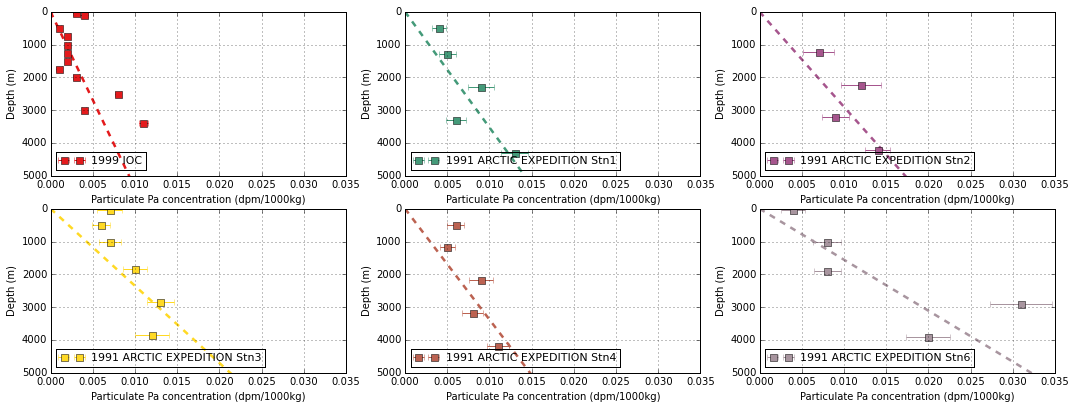

In [3]:
#ax = plt.figure(1,figsize=(10,7))
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    
    y= data['depth'];
    name= data['name'][0];
    x=data['231Pa part.'];
    lon = data['long.'];
    lat = data['lat.'];
    err =data['Pa_part_err']
    
    x=np.ma.masked_where(x<=0,x)
    y=np.ma.masked_where(x<=0,y)
    err=np.ma.masked_where(x<=0,err)
    
    y2 = sm.add_constant(y,prepend=False)
    mod_wls = sm.WLS(x, y2, weights=1./err)
    res_wls = mod_wls.fit()
    
    WLS_err1[j,:] = res_wls.bse[0]
    WLS_coef1[j,:] = res_wls.params[0]
    WLS_coefc[j,:]=res_wls.params[1]
    sinking_rate[j,:]=0.00246/res_wls.params[0]
    err1=(WLS_err1/WLS_coef1)*1/WLS_coef1*0.00246
    
    ftest=sm.WLS(x, y, weights=1./err).fit()
    rss1[j]=ftest.mse_resid
    rss2[j]=res_wls.mse_resid
    p1 = 1
    p2 = 2
    n = file_num
    F = (ftest.mse_resid - res_wls.mse_resid)/(res_wls.mse_resid) *(n-p2)/(p2-p1)
    p = 1.0 - scist.cdf(F,p2-p1,n-p2)
    print ('')
    print (name)
    print ('F ratio: %s'%F)
    print ('ftest:%s'%p)
    print ('slope:%e,error:%e'%(res_wls.params[0],res_wls.bse[0]))
    print ('C1   :%e,error:%e'%(res_wls.params[1],res_wls.bse[1]))
    print ('sinking   :%e,error:%e'%(sinking_rate[j,:],err1[j,:]))


    #ax = plt.subplot()
    ax = plt.figure(1,figsize=(18,10))
    ax = plt.subplot(3,3,j+1)
    #ax.plot([0, 5000],[0, 5000]/res_wls.params[0]-res_wls.params[1]/res_wls.params[0], '--.',c=cm.Set1(j*50),linewidth=2.5)
    ax.plot([0, 5000],[0, 5000]/ftest.params[0], '--.',c=cm.Set1(j*50),linewidth=2.5)
    ax.errorbar(x, y,xerr=err, fmt='s',markersize=7,c=cm.Set1(j*50),label=name)
    ax.legend(loc=3,fontsize=11)
    
    ax.set_ylim([0, 5000])
    ax.set_xlim([0, 0.035])
#    if j+1==1 or j+1==4:
    plt.ylabel('Depth (m)')
#    if j+1==5:
    plt.xlabel('Particulate Pa concentration (dpm/1000kg)')
#    if j+1==1 or j+1==2 or j+1==3:
#        plt.setp(ax.get_xticklabels(), visible=False)
#    if not (j+1==1 or j+1==4):
#        plt.setp(ax.get_yticklabels(), visible=False)
#    plt.subplots_adjust(wspace=.0000001, hspace=.0000001)

    plt.grid()
    plt.gca().invert_yaxis()
    #plt.tight_layout()
plt.show()

# total F-test

In [4]:
p1 = 1
p2 = 2
n = file_num
F = (sum(rss1) - sum(rss2))/(sum(rss2)) *(n*n-p2*n)/(p2*n-p1*n)
p = 1.0 - scist.cdf(F,p2-p1,n-p2)
print ('F ratio: %s'%F)
print ('ftest:%s'%p)

F ratio: -0.303113511882
ftest:1.0


#Fitting the diss. Pa

####(1) Change into fit Q-C{1}K{-1}-K{-1}Qz/S (With inercepts)

In [5]:
WLS_err2=np.empty([file_num,1])
Kvalue=np.empty([file_num,1])
WLS_coef2=np.empty([file_num,1])


1999 IOC
F ratio: 7.55849681287
ftest:0.0514128785617
slope:2.293488e+00,error:4.878957e-06
C1   :9.713191e-02,error:9.954861e-03
K   :4.360171e-01,error:6.322994e-01

1991 ARCTIC EXPEDITION Stn1
F ratio: 49.6424906508
ftest:0.00213924721573
slope:2.766238e+01,error:4.878957e-06
C1   :1.582026e-01,error:9.954861e-03
K   :3.615017e-02,error:6.476587e-03

1991 ARCTIC EXPEDITION Stn2
F ratio: 65.2559814333
ftest:0.00127583785932
slope:3.265482e+01,error:4.878957e-06
C1   :1.916906e-01,error:9.954861e-03
K   :3.062335e-02,error:8.794359e-03

1991 ARCTIC EXPEDITION Stn3
F ratio: 87.0604085211
ftest:0.000734453893159
slope:7.751084e+01,error:4.878957e-06
C1   :3.951620e-01,error:9.954861e-03
K   :1.290142e-02,error:2.505433e-03

1991 ARCTIC EXPEDITION Stn4
F ratio: 184.857265798
ftest:0.000169424415085
slope:3.084714e+01,error:4.878957e-06
C1   :2.014877e-01,error:9.954861e-03
K   :3.241792e-02,error:7.193416e-03

1991 ARCTIC EXPEDITION Stn6
F ratio: 164.539112287
ftest:0.000212920913597
sl

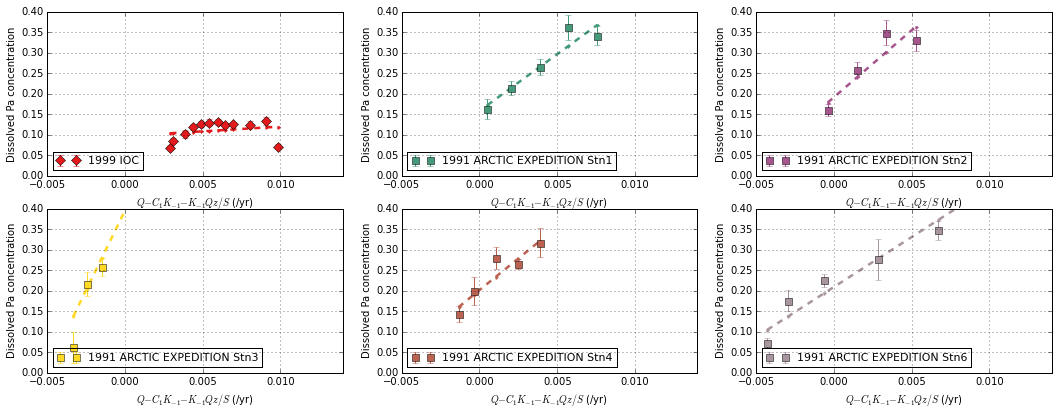

In [6]:
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    
    y= data['depth'];
    x= data['231Pa diss.'];
    name= data['name'][0];
    lon = data['long.'];
    lat = data['lat.'];
    err =data['Pa_diss_err']
    
    x=np.ma.masked_where(x<=0,x)
    y=np.ma.masked_where(x<=0,y)
    err=np.ma.masked_where(x<=0,err)      
    x=x.compressed()
    y=y.compressed()
    err=err.compressed()
    y2=np.empty(len(x))
    for k in range (len(x)):
         y2[k]=(0.00246-WLS_coefc[j,:])+(WLS_coef1[j,:]*y[k])

    y3 = sm.add_constant(y2,prepend=False)

    mod_wls2 = sm.WLS(x,y3, weights=1./err)
    res_wls2 = mod_wls2.fit()
    
    WLS_err2[j,:] = res_wls2.bse[0]
    Kvalue[j,:]=1/res_wls2.params[0]
    WLS_coef2[j,:] = res_wls2.params[0]
    #err2=((WLS_err1/WLS_coef1)+(WLS_err2/WLS_coef2))* WLS_coef1/WLS_coef2
    ftest=sm.WLS(x, y2, weights=1./err).fit()
    err2=res_wls2.bse[0]/res_wls2.params[0]*Kvalue
    rss1[j]=ftest.mse_resid
    rss2[j]=res_wls2.mse_resid
    
    p1 = 1
    p2 = 2
    n = file_num
    F = (ftest.mse_resid - res_wls2.mse_resid)/(res_wls2.mse_resid) *(n-p2)/(p2-p1)
    p = 1.0 - scist.cdf(F,p2-p1,n-p2)
    print ('')
    print (name)
    print ('F ratio: %s'%F)
    print ('ftest:%s'%p)
    print ('slope:%e,error:%e'%(res_wls2.params[0],res_wls.bse[0]))
    print ('C1   :%e,error:%e'%(res_wls2.params[1],res_wls.bse[1]))
    print ('K   :%e,error:%e'%(Kvalue[j,:],err2[j,:]))
    
    ax = plt.figure(1,figsize=(18,10))
    ax = plt.subplot(3,3,j+1)
    ax.plot(y2, res_wls2.fittedvalues, '--.',c=cm.Set1(j*50),linewidth=2.5)
    ax.errorbar(y2,x,yerr=err, fmt=marker[j],markersize=7,c=cm.Set1(j*50),label=name)    
    ax.legend(loc=3,fontsize=11)
    ax.set_ylim([0, 0.4])
    ax.set_xlim([-0.005, 0.014])
#    if j+1==1 :
    plt.ylabel('Dissolved Pa concentration')#(dpm/1000kg)')
#    if j+1==4:
#        plt.ylabel('Dissolved Pa concentration')
#    if j+1==3 or j+1==4 or j+1==5:
    plt.xlabel('$Q-C_{1}K_{-1}-K_{-1}Qz/S$ (/yr)')
#    if j+1==1 or j+1==2:
#        plt.setp(ax.get_xticklabels(), visible=False)
#    if not (j+1==1 or j+1==4):
#        plt.setp(ax.get_yticklabels(), visible=False)
#    plt.subplots_adjust(wspace=.0000001, hspace=.0000001)
    plt.grid() 
#    print(name,'p_value',round(res_wls2.pvalues[0],3),'C',round(res_wls2.params[1],3))
#    print(name,'k_pa',1/res_wls2.params[0])
plt.show()

In [7]:
print res_wls2.summary()

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.952
Model:                            WLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     79.31
Date:                Wed, 08 Jul 2015   Prob (F-statistic):           0.000879
Time:                        13:34:24   Log-Likelihood:                 1.1763
No. Observations:                   6   AIC:                             1.647
Df Residuals:                       4   BIC:                             1.231
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            24.3437      2.734      8.906      0.001        16.754    31.933
const          0.2092      0.015     14.376      0.0

# WLS: sinking rate and the ice concentration

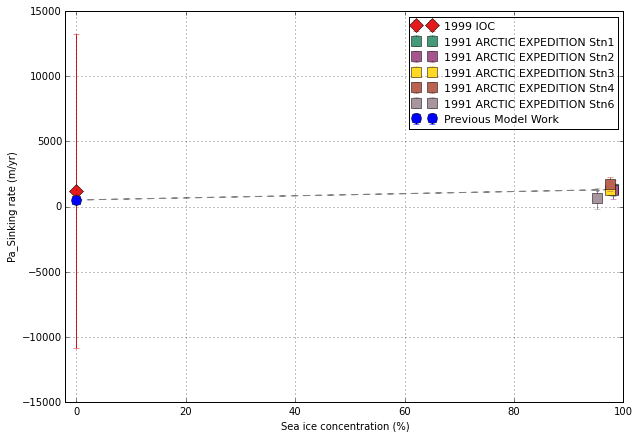

In [8]:
marker=['D','s','s','s','s','s','s']
#i=np.empty([5,1])
#for j in range(5):
#    data=pd.read_csv(nc_filename[j])
#    i[j,:]= data['ice'][0];
i= np.array([0,98,98,97.6,97.6,95.2])
    
err1=(WLS_err1/WLS_coef1)*1/WLS_coef1*0.00246
#((WLS_err1/WLS_coef1)**2)**(0.5)
sinking_rate=numpy.append(sinking_rate,500)
i=numpy.append(i,0)
err1=numpy.append(err1,0.01)
i2 = sm.add_constant(i,prepend=False)
mod_wls3 = sm.WLS(sinking_rate,i2,weights=1./err1) #Is it the real error?
res_wls3 = mod_wls3.fit()

fig, ax = plt.subplots(1,figsize=(10,7))
ax.plot(i, res_wls3.fittedvalues, '--.',color='grey')
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],sinking_rate[j],yerr=err1[j],fmt=marker[j],markersize=10,c=cm.Set1(j*50),label=name)

ax.errorbar(i[-1],sinking_rate[-1], yerr=err1[-1], fmt='o',markersize=10,c='blue',label='Previous Model Work')
ax.legend(loc=0, fontsize=11)#,bbox_to_anchor=(1.45,1))
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Pa_Sinking rate (m/yr)')

#ax.set_ylim([0, 5000])
ax.set_xlim([-2, 100])
plt.grid()
plt.show()

In [9]:
print res_wls3.summary()

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.877
Model:                            WLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     35.56
Date:                Wed, 08 Jul 2015   Prob (F-statistic):            0.00190
Time:                        13:34:25   Log-Likelihood:                -26.879
No. Observations:                   7   AIC:                             57.76
Df Residuals:                       5   BIC:                             57.65
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             8.1456      1.366      5.963      0.002         4.634    11.657
const        500.0004      1.332    375.444      0.0

# WLS: K value and the ice concentration

####(1)fit the whole formula

In [10]:
#print Kvalue
#print err2

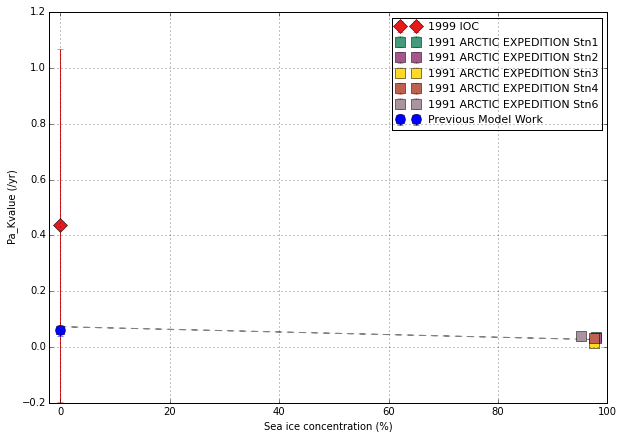

In [11]:
err2=WLS_err2/WLS_coef2*Kvalue
#err2= ((WLS_err1/WLS_coef1)+(WLS_err2/WLS_coef2))* WLS_coef1/WLS_coef2# error of k value K-1=1
#(WLS_coef1**(-4)*(WLS_coef2**(-2))*(WLS_err1)**2+WLS_coef2**(-4)*(WLS_coef1**(-2))*(WLS_err2)**2)**(0.5)
#((WLS_err1/WLS_coef1)**2+(WLS_err2/WLS_coef2)**2)**(0.5) # error of k value K-1=1

Kvalue=numpy.append(Kvalue,0.06)#0.06
err2=numpy.append(err2,0.02)

mod_wls4 = sm.WLS(Kvalue, i2, weights=1./(err2))
res_wls4 = mod_wls4.fit()

fig, ax = plt.subplots(1,figsize=(10,7))
ax.plot(i, res_wls4.fittedvalues,  '--.',color='grey')
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],Kvalue[j],yerr=err2[j],fmt=marker[j],markersize=10,c=cm.Set1(j*50),label=name)
errorbar(i[-1],Kvalue[-1], yerr=err2[-1], fmt='o',markersize=10,c='blue',label='Previous Model Work')
ax.legend(loc=0,fontsize=11)
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Pa_Kvalue (/yr)')
ax.set_xlim([-2, 100])
plt.grid()
plt.show()

In [12]:
print res_wls4.summary()

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.227
Model:                            WLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     1.468
Date:                Wed, 08 Jul 2015   Prob (F-statistic):              0.280
Time:                        13:34:26   Log-Likelihood:                0.53578
No. Observations:                   7   AIC:                             2.928
Df Residuals:                       5   BIC:                             2.820
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0005      0.000     -1.212      0.280        -0.001     0.001
const          0.0727      0.037      1.972      0.1

In [13]:
from statsmodels.formula.api import wls
from scipy.stats import f as scist
data = pd.DataFrame({'Kvalue':Kvalue, 'i3': i})
mod_wls6 = wls('Kvalue~i3', data,weights=1./(err2))
res_wls6 = mod_wls6.fit()
#print res_wls6.summary()

b=average(Kvalue)
print ('average k:%s'%b)
rss2=(Kvalue-b)**2
rss2_sum=sum(rss2)

print ('rss(model constant):%s'%rss2_sum)
print ('rss(model 2df):%s'%res_wls6.mse_resid)

p1 = 1
p2 = 2
n = file_num
F = (rss2_sum - res_wls6.mse_resid)/(res_wls6.mse_resid) *(n-p2)/(p2-p1)
p = 1.0 - scist.cdf(F,p2-p1,n-p2)
print ('F ratio: %s'%F)
print ('pvalue:%s'%p)
#print ("If the F calculated from the data is greater than the critical value of the F-distribution (0.05),model with 2 degrees of freedom sometimes provide a significantly better fit than model with 1 degree of freedom.")

average k:0.092741200922
rss(model constant):0.138653828097
rss(model 2df):0.0703350165445
F ratio: 3.88533705734
pvalue:0.120014655808


# Map

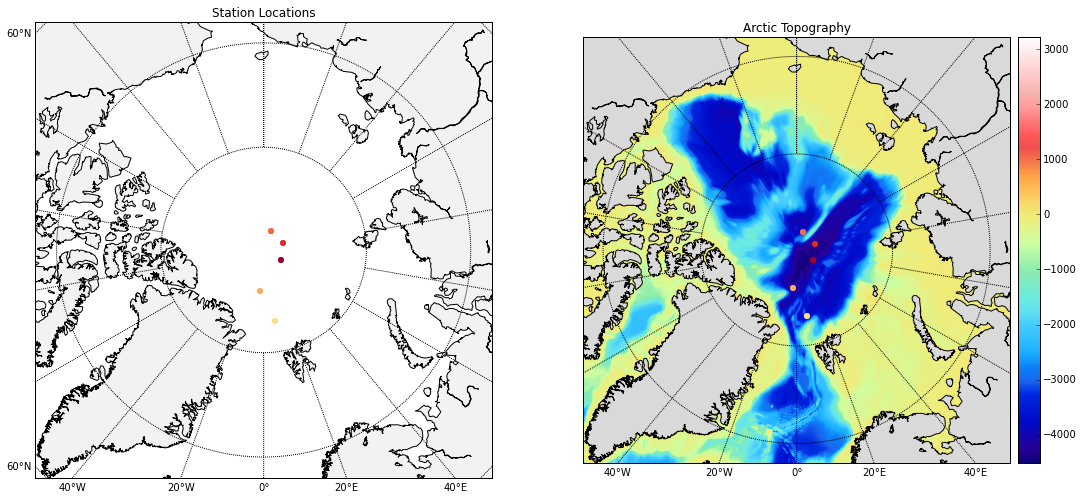

In [21]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(121)

# create Basemap instance.
m = Basemap(projection='npstere',boundinglat=68,lon_0=0,resolution='l')
for j in range(5):
    data=pd.read_csv(nc_filename[j])
    lon = data['long.'];
    lat = data['lat.'];
    x,y = m(lon.values,lat.values)
    m.scatter(x,y,color=cm.RdYlGn(j*25))
    
plt.title("Station Locations")
m.drawcoastlines()
m.fillcontinents(color = '0.95')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

ax = fig.add_subplot(122)
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo5.nc'
etopodata = Dataset(url)

topoin = etopodata.variables['ROSE'][:]
lons = etopodata.variables['ETOPO05_X'][:]
lats = etopodata.variables['ETOPO05_Y'][:]
# shift data so lons go from -180 to 180 instead of 20 to 380.
topoin,lons = shiftgrid(180.,topoin,lons,start=False)
m = Basemap(projection='npstere',boundinglat=68,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.85')
m.drawparallels(np.arange(-80.,81.,15.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

for j in range(5):
    data=pd.read_csv(nc_filename[j])
    lon = data['long.'];
    lat = data['lat.'];
    x,y = m(lon.values,lat.values)
    m.scatter(x,y,color=cm.RdYlGn(j*25))

nx = int((m.xmax-m.xmin)/5000.)+1; ny = int((m.ymax-m.ymin)/5000.)+1
topodat = m.transform_scalar(topoin,lons,lats,nx,ny)    
from mpl_toolkits.basemap import cm    
im = m.imshow(topodat,cm.GMT_haxby)
cb = m.colorbar(im,"right", size="5%", pad='2%')
plt.title("Arctic Topography")
plt.show()